# 1. Simple Stochastic Example


This example shows how to calculate TVOG (Time Value of Options and Guarantees) on a plain variable annuity product with GMAB by two methods, Monte Carlo simulation with 10,000 risk-neutral scenaios and the Black-Scholes-Merton option pricing formula for European put options.

For this example, the `CashValue_ME_EX1` model is developed from `CashValue_ME` and included in the `savings` library. This Jupyter notebook describes `CashValue_ME_EX1`, and explains the changes made to devolop `CashValue_ME_EX1` from `CashValue_ME.`

To make the results easily comparable, the `CashValue_ME_EX1` model assumes no policy decrement and no fees(i.e. mortality and lapse assumptions, M&E fees and COI chages are set to 0 in the model).


## Change summary

The following page shows a complete comparison of formulas between `CashValue_ME_EX1` and `CashValue_ME` with highlights on updated parts.

https://www.diffchecker.com/rKGSoxPL


The following cells are newly added in `CashValue_ME_EX1`. `std_norm_rand` is changed from a Reference to a Cells.

* `claim_net_pp`
* `formula_option_put`
* `pv_claims_from_av`
* `scen_index`
* `std_norm_rand`

The formulas of the following cells are updated.

* `claim_pp`
* `coi_rate`
* `inv_return_mth`
* `inv_return_table`
* `lapase_rate`
* `maint_fee_rate`
* `model_point`
* `mort_rate`

<div class="alert alert-warning">

**Warning:**

`CashValue_ME_EX1` is based on `CashValue_ME` in lifelib v0.13.1. Changes made on `CashValue_ME` newer than v0.13.1 may not be reflacted in `CashValue_ME_EX1`.

</div>



Click the badge below to run this notebook online on Google Colab. You need a Google account and need to be logged in to it to run this notebook on Google Colab.
[![Run on Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lifelib-dev/lifelib/blob/current/lifelib/libraries/savings/savings_example1.ipynb)


The next code cell below is relevant only when you run this notebook on Google Colab. It installs lifelib and creates a copy of the library for this notebook.

In [1]:
import sys, os

if 'google.colab' in sys.modules:
    lib = 'savings'; lib_dir = '/content/'+ lib
    if not os.path.exists(lib_dir):
        !pip install lifelib
        import lifelib; lifelib.create(lib, lib_dir)
        
    %cd $lib_dir

The code below imports essential modules, reads the `CashValue_ME_EX1` model into Python, and defines `proj` as an alias for the `Projection` in the model for convenience. 

In [2]:
import numpy as np
import pandas as pd
import modelx as mx

model = mx.read_model('CashValue_ME_EX1')
proj = model.Projection

## Input data

By defalut, a model point table with a single model piont is assigned to `model_point_table` (and also to `model_point_1`). The model point is 100 of 10-year new business policies whose initial premiums are all 450,000 and sum assureds are all 500,000. There is another table, `model_point_moneyness`, defined in the model, which is used later for calculating TVOG for varying levels of initial account value. 

In [3]:
proj.model_point_table

,spec_id,age_at_entry,sex,policy_term,policy_count,sum_assured,duration_mth,premium_pp,av_pp_init,accum_prem_init_pp
poind_id,,,,,,,,,,
1,A,20,M,10,100,500000,0,450000,0,0


The product spec table is slightly modified from the one in `CashValue_ME`. `load_prem_rate` is changed to 0 for the product `A`. In this example, the level of account value against sum assured at issue is controled by `premium_pp` in `model_point_table`, not by `load_prem_rate` in `product_spec_table`.

In [4]:
proj.product_spec_table

,premium_type,has_surr_charge,surr_charge_id,load_prem_rate,is_wl
spec_id,,,,,
A,SINGLE,False,NaN,0.00,False
B,SINGLE,True,type_1,0.00,False
C,LEVEL,False,NaN,0.10,True
D,LEVEL,True,type_3,0.05,True


Discount rates are read from *disc_rate_ann.xlsx* into `disc_rate_ann`. To make Monte Calo and Black-Scholes-Merton comparable, a constant continuous compound rate of 2% is assumed for discounting. `disc_rate_ann` holds the annual compound rate converted from the continuous compound rate of 2%. 

In [5]:
proj.disc_rate_ann

year
0      0.020201
1      0.020201
2      0.020201
3      0.020201
4      0.020201
         ...   
146    0.020201
147    0.020201
148    0.020201
149    0.020201
150    0.020201
Name: zero_spot, Length: 151, dtype: float64

## Turing  off policy decrement and fees

To make this example simple, policy decrement and fees are all set to 0 in `CashValue_ME_EX1`. Changes are made to relevant formulas. For example, the formula of `lapse_rate` now returns a Series of 0 as shown below. The docstring is not udated from the original formula.

In [6]:
proj.lapse_rate.formula

def lapse_rate(t):
    """Lapse rate

    By default, the lapse rate assumption is defined by duration as::

        max(0.1 - 0.02 * duration(t), 0.02)

    .. seealso::

        :func:`duration`

    """
    # return np.maximum(0.1 - 0.02 * duration(t), 0.02)
    return pd.Series(0, index=model_point().index)

## Adding GMAB

By default, the products in `CashValue_ME` have no minimum guarantee on maturity benefits. To add GMAB, some formulas are added or updated in `CashValue_ME_EX1` as shown below. Docstrings are not updated.

In [7]:
proj.claim_net_pp.formula

def claim_net_pp(t, kind):

    if kind == "DEATH":
        return claim_pp(t, "DEATH") - av_pp_at(t, "MID_MTH")

    elif kind == "LAPSE":
        return 0

    elif kind == "MATURITY":
        return claim_pp(t, "MATURITY") - av_pp_at(t, "BEF_PREM")

    else:
        raise ValueError("invalid kind")

In [8]:
proj.claim_pp.formula

def claim_pp(t, kind):
    """Claim per policy

    The claim amount per policy. The second parameter
    is to indicate the type of the claim, and
    it takes a string, which is either ``"DEATH"``, ``"LAPSE"`` or ``"MATURITY"``.

    The death benefit as denoted by ``"DEATH"``, is
    the greater of :func:`sum_assured` and
    mid-month account value (:func:`av_pp_at(t, "MID_MTH")<av_pp_at>`).

    The surrender benefit as denoted by ``"LAPSE"`` and
    the maturity benefit as denoted by ``"MATURITY"`` are
    equal to the mid-month account value.

    .. seealso::

        * :func:`sum_assured`
        * :func:`av_pp_at`

    """

    if kind == "DEATH":
        return np.maximum(sum_assured(), av_pp_at(t, "MID_MTH"))

    elif kind == "LAPSE":
        return av_pp_at(t, "MID_MTH")

    elif kind == "MATURITY":
        return np.maximum(sum_assured(), av_pp_at(t, "BEF_PREM"))

    else:
        raise ValueError("invalid kind")

## Making the model stochastic

The approach taken for this example to make `CashValue_ME` stochastic is to index `model_point` not by model point ID, but by the combination of scenaio ID and model point ID.
Based on this approach, the `model_point` DataFrame has a MultiIndex, which has two levels, scenario ID denoted by `scen_id` and model point ID denoted by `point_id`, and now the number of rows in `model_point` is the number of scenaios times the number of model points. For each model point ID, there are identical model points as many as the number of scnarios.

This approach consumes more memory, but the changes to be made in the model are minimal, and the model runs fast because an identical operation on all the model points across all the scenarios can be performed at the same time as a vector operation along the MultiIndex of `model_point`.

To make `model_point` indexed with `scen_id` and `point_id`, its formula is changed as follows. The docstring is not updated.


In [9]:
proj.model_point.formula

def model_point():
    """Target model points

    Returns as a DataFrame the model points to be in the scope of calculation.
    By default, this Cells returns the entire :func:`model_point_table_ext`
    without change.
    :func:`model_point_table_ext` is the extended model point table,
    which extends :attr:`model_point_table` by joining the columns
    in :attr:`product_spec_table`. Do not directly refer to
    :attr:`model_point_table` in this formula.
    To select model points, change this formula so that this
    Cells returns a DataFrame that contains only the selected model points.

    Examples:
        To select only the model point 1::

            def model_point():
                return model_point_table_ext().loc[1:1]

        To select model points whose ages at entry are 40 or greater::

            def model_point():
                return model_point_table[model_point_table_ext()["age_at_entry"] >= 40]

    Note that the shape of the returned DataFrame must be t

Now `model_point` looks like below. Since `model_point_table` has only one model point, `model_point` has 10,000 rows. When the current table is replaced with the other one with 9 model points later in this example, `model_point` will have 90,000 rows.

In [10]:
proj.model_point()

spec_id  age_at_entry sex  policy_term  policy_count  \
poind_id scen_id                                                        
1        1             A            20   M           10           100   
         2             A            20   M           10           100   
         3             A            20   M           10           100   
         4             A            20   M           10           100   
         5             A            20   M           10           100   
...                  ...           ...  ..          ...           ...   
         9996          A            20   M           10           100   
         9997          A            20   M           10           100   
         9998          A            20   M           10           100   
         9999          A            20   M           10           100   
         10000         A            20   M           10           100   

                  sum_assured  duration_mth  premium_pp  av_pp_init  \
poind_id scen_id                                                      
1        1             500000             0      450000           0   
         2             500000             0      450000           0   
         3             500000             0      450000           0   
         4             500000             0      450000           0   
         5             500000             0      450000           0   
...                       ...           ...         ...         ...   
         9996          500000             0      450000           0   
         9997          500000             0      450000           0   
         9998          500000             0      450000           0   
         9999          500000             0      450000           0   
         10000         500000             0      450000           0   

                  accum_prem_init_pp premium_type  has_surr_charge  \
poind_id scen_id                                                     
1        1                         0       SINGLE            False   
         2                         0       SINGLE            False   
         3                         0       SINGLE            False   
         4                         0       SINGLE            False   
         5                         0       SINGLE            False   
...                              ...          ...              ...   
         9996                      0       SINGLE            False   
         9997                      0       SINGLE            False   
         9998                      0       SINGLE            False   
         9999                      0       SINGLE            False   
         10000                     0       SINGLE            False   

                 surr_charge_id  load_prem_rate  is_wl  
poind_id scen_id                                        
1        1                  NaN             0.0  False  
         2                  NaN             0.0  False  
         3                  NaN             0.0  False  
         4                  NaN             0.0  False  
         5                  NaN             0.0  False  
...                         ...             ...    ...  
         9996               NaN             0.0  False  
         9997               NaN             0.0  False  
         9998               NaN             0.0  False  
         9999               NaN             0.0  False  
         10000              NaN             0.0  False  

[10000 rows x 15 columns]

In `CashValue_ME`, `std_norm_rand` is a Series of random numbers read from an input file. In `CashValue_ME_EX1`, `std_norm_rand` generates random numbers that follow the standard normal distribution.
Depending the version of NumPy, a different random number generator is used. `std_norm_rand` generates random numbers for `t=0` through `t=241`, although scenarios only up to `t=120` are used in this example.
For each `t`, 10,000 random numbers are generated.


In [11]:
proj.std_norm_rand.formula

def std_norm_rand():

    if hasattr(np.random, 'default_rng'):

        gen = np.random.default_rng(1234)
        rnd = gen.standard_normal(scen_size * 242)

    else:
        np.random.seed(1234)
        rnd = np.random.standard_normal(size=scen_size * 242)

    idx = pd.MultiIndex.from_product(
            [range(1, scen_size + 1), range(242)],
            names = ['scen_id', 't']
        )

    return pd.Series(rnd, index=idx)

In [12]:
proj.std_norm_rand()

scen_id  t  
1        0     -1.603837
         1      0.064100
         2      0.740891
         3      0.152619
         4      0.863744
                  ...   
10000    237   -0.191942
         238    1.541354
         239   -0.566613
         240    1.198116
         241   -2.349542
Length: 2420000, dtype: float64

The graph show how well the 10,000 random numbers generated for `t=0` fit the PDF of the standard normal distribution.

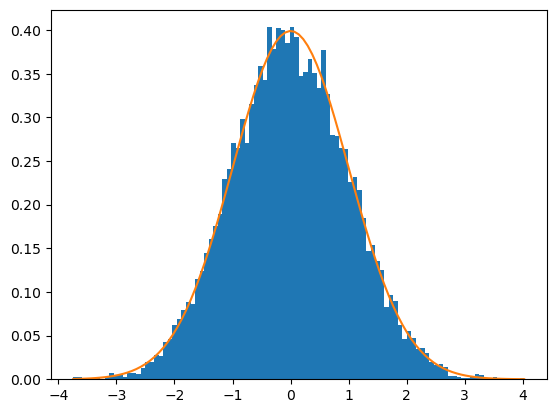

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import norm

t = 0
num_bins = 100

fig, ax = plt.subplots()
n, bins, patches = ax.hist(proj.std_norm_rand()[:,t], bins=num_bins, density=True)
ax.plot(bins, norm.pdf(bins), '-')
plt.show()

## Stochastic account value projection

Using on the generated random numbers, the account value is projected stochastically. 10,000 paths are generated. The graph below shows the first 100 paths.

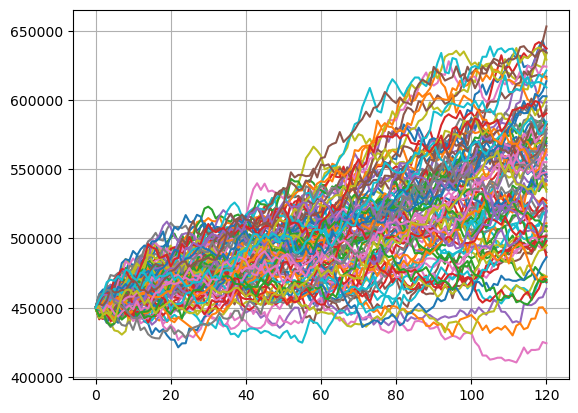

In [14]:
avs = list(proj.av_pp_at(t, 'BEF_FEE') for t in range(proj.max_proj_len()))
df = pd.DataFrame(avs)[1]
scen_size = 100

df[range(1, scen_size + 1)].plot.line(legend=False, grid=True)
plt.show()

The investment return on the account value is modeled to follow the geometric Brownian motion:

$$\frac{\Delta{S}}{S}=r\Delta{t}+\sigma\epsilon\sqrt{\Delta{t}}$$

where $\Delta{S}$ is the change in the account value $S$ in a small interval of time, $\Delta{t}$. $r$ is the constant risk free rate, $\sigma$ is the volatility of the account value and $\epsilon$ is a random number drawn from the standard normal distribution.

The distibution of the account value at `t=120` follows a log normal distribution. In the expression below, $S_{T}$ and $S_{0}$ denote account value at $t=T$ and $t=0$ respectively. 


$$\ln\frac{S_{T}}{S_{0}}\sim\phi\left[\left(r-\frac{\sigma^{2}}{2}\right)T, \sigma\sqrt{T}\right]$$



The graph shows how well the distribution of $e^{-rT}S_{T}$, the present values of the account value at `t=0`, fits the PDF of a log normal ditribution.

Reference: *Options, Futures, and Other Derivatives* by John C.Hull


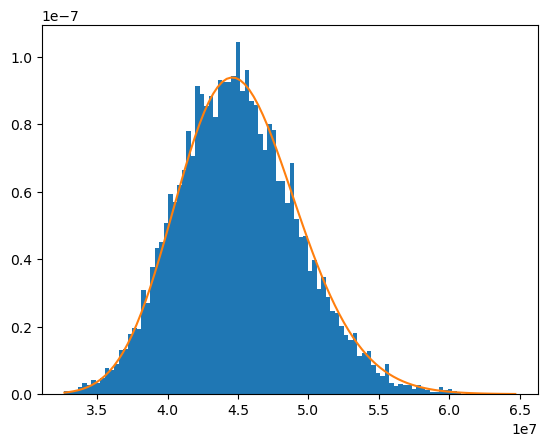

In [15]:
from scipy.stats import lognorm

S0 = 45000000
sigma = 0.03
T = 10

ST = model.Projection.pv_claims_from_av('MATURITY')
fig, ax = plt.subplots()
n, bins, patches = ax.hist(ST, bins=num_bins, density=True)
ax.plot(bins, lognorm.pdf(bins, sigma * T**0.5, scale=S0), '-')
plt.show()

Since the scenarios are risk neutral, the following equation should hold.

$$S_{0}=E\left[e^{-rT}S_{T}\right]$$ 

In [16]:
np.average(ST)

45017755.8731498

In [17]:
np.average(ST) / S0

1.0003945749588843

## Comparing Monte Calo with Black-Scholes-Merton formula

To check the Monte Carlo result, the Black-Scholes-Merton formula for pricing European put options is added to the model.$X$ corresponds to the sum assured in this example.

$$
p=Xe^{-rT}N\left(-d_{2}\right)-S_{0}N\left(-d_{1}\right)
$$

$$
d_{1}=\frac{\ln\left(\frac{S_{0}}{X}\right)+\left(r+\frac{\sigma^{2}}{2}\right)T}{\sigma\sqrt{T}}
$$

$$
d_{2}=d_{1}-\sigma\sqrt{T}
$$


Reference: *Options, Futures, and Other Derivatives* by John C.Hull

In [18]:
proj.formula_option_put.formula

def formula_option_put(t):
    """
        S: prem_to_av
        X: claims
        sigma: 0.03
        r: 0.02

    """
    mps = model_point_table_ext()
    cond = mps['policy_term'] * 12 == t
    mps = mps.loc[cond]

    T = t / 12
    S = av_at(0, 'BEF_FEE')[:, 1][cond]
    X = (sum_assured() * pols_maturity(t))[:, 1][cond]
    sigma = 0.03
    r = 0.02
    N = stats.norm.cdf
    e = np.exp

    d1 = (np.log(S/X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return X * e(-r*T) * N(-d2) - S * N(-d1)

To get results for various in-the-moneyness, `model_point_table` is replaced with the other table, `model_point_moneyness`.
`model_point_moneyness` has 9 model points whose initial account values range from 300,000 to 500,000 by the 25,000 interval

In [19]:
proj.model_point_table = proj.model_point_moneyness
proj.model_point_table

,spec_id,age_at_entry,sex,policy_term,policy_count,sum_assured,duration_mth,premium_pp,av_pp_init,accum_prem_init_pp
point_id,,,,,,,,,,
1,A,20,M,10,100,500000,0,500000,0,0
2,A,20,M,10,100,500000,0,475000,0,0
3,A,20,M,10,100,500000,0,450000,0,0
4,A,20,M,10,100,500000,0,425000,0,0
5,A,20,M,10,100,500000,0,400000,0,0
6,A,20,M,10,100,500000,0,375000,0,0
7,A,20,M,10,100,500000,0,350000,0,0
8,A,20,M,10,100,500000,0,325000,0,0
9,A,20,M,10,100,500000,0,300000,0,0


`pv_claims_over_av('MATURITY')` returns the present value of GMAB payouts in Numpy array. The code below converts the array into Series by adding the MultiIndex of `model_point`.

In [20]:
result = pd.Series(proj.pv_claims_over_av('MATURITY'), index=proj.model_point().index)
result

point_id  scen_id
1         1          0.000000e+00
          2          0.000000e+00
          3          0.000000e+00
          4          0.000000e+00
          5          0.000000e+00
                         ...     
9         9996       1.083556e+07
          9997       1.360538e+07
          9998       1.362055e+07
          9999       1.487216e+07
          10000      1.335670e+07
Length: 90000, dtype: float64

By taking the mean of all the scenarios for each `point_id`, TVOGs by Monte Carlo are obtained.

In [21]:
monte_carlo = result.groupby(level='point_id').mean()
monte_carlo

point_id
1    2.658845e+04
2    1.012275e+05
3    3.338084e+05
4    9.112496e+05
5    2.036347e+06
6    3.785184e+06
7    6.000904e+06
8    8.434895e+06
9    1.092539e+07
dtype: float64

The code below shows the same results obtained from the Black-Scholes-Merton formula, and the both results are compared and plotted in the graph below.

In [22]:
black_scholes = proj.formula_option_put(120)
black_scholes

point_id
1    2.711649e+04
2    1.048409e+05
3    3.405594e+05
4    9.180829e+05
5    2.044594e+06
6    3.793290e+06
7    6.010317e+06
8    8.445057e+06
9    1.093700e+07
dtype: float64

In [23]:
monte_carlo / black_scholes

point_id
1    0.980527
2    0.965534
3    0.980177
4    0.992557
5    0.995966
6    0.997863
7    0.998434
8    0.998797
9    0.998938
dtype: float64

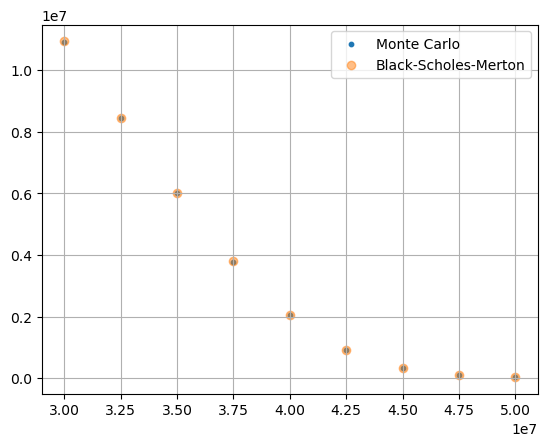

In [24]:
S0 = proj.model_point_table['premium_pp'] * proj.model_point_table['policy_count']
    
fig, ax = plt.subplots()
ax.scatter(S0, monte_carlo, s= 10, alpha=1, label='Monte Carlo')
ax.scatter(S0, black_scholes, alpha=0.5, label='Black-Scholes-Merton')
ax.legend()
ax.grid(True)
plt.show()